<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Simulate_PerGroup_DeltaFC_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Simulate_PerGroup_DeltaFC_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulate Per-Group Models & Validate with Subject-Specific ΔFC

Generate synthetic TMS-fMRI sessions using target-specific models trained per-group.
For each subject, generate:
- Rest sessions: one per stim session (matched pairs)
- Stim sessions: using their target-specific model with real stimulation timing

Then validate by comparing empirical vs. simulated ΔFC = FC_stim - FC_rest per subject.

In [1]:
# =========================
# 0) Mount Google Drive
# =========================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# =========================
# 1) Clone repo + imports
# =========================
import os, sys, pickle, json, math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import defaultdict

REPO_DIR = "/content/BrainStim_ANN_fMRI_HCP"
if not os.path.exists(REPO_DIR):
    !git clone https://github.com/grabuffo/BrainStim_ANN_fMRI_HCP.git
else:
    print("Repo already exists ✅")

sys.path.append(REPO_DIR)

from src.NPI import build_model, device
print("Torch device:", device)

Cloning into 'BrainStim_ANN_fMRI_HCP'...
remote: Enumerating objects: 570, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 570 (delta 20), reused 14 (delta 14), pack-reused 538 (from 1)
Receiving objects: 100% (570/570), 81.94 MiB | 35.14 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Torch device: cuda:0


In [3]:
# =========================
# 2) Paths (EDIT IF NEEDED)
# =========================
BASE = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data"

DATASET_EMP_PKL = os.path.join(BASE, "TMS_fMRI", "dataset_tian50_schaefer400_allruns.pkl")
GROUPING_SUMMARY_PKL = os.path.join(BASE, "TMS_fMRI", "target_regions_grouping_summary.pkl")

PREPROC_ROOT = os.path.join(BASE, "preprocessed_subjects_tms_fmri")
MODELS_DIR = os.path.join(PREPROC_ROOT, "trained_models_MLP_tms_fmri_pergroup")

OUT_DIR = os.path.join(PREPROC_ROOT, "ANN_vs_tms_fmri_pergroup")
os.makedirs(OUT_DIR, exist_ok=True)
OUT_PKL = os.path.join(OUT_DIR, "dataset_simulated_pergroup_ANN.pkl")

print("Empirical dataset:", DATASET_EMP_PKL, "| exists:", os.path.exists(DATASET_EMP_PKL))
print("Grouping summary:", GROUPING_SUMMARY_PKL, "| exists:", os.path.exists(GROUPING_SUMMARY_PKL))
print("Models directory:", MODELS_DIR, "| exists:", os.path.exists(MODELS_DIR))
print("Will save to:", OUT_PKL)

Empirical dataset: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl | exists: True
Grouping summary: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/TMS_fMRI/target_regions_grouping_summary.pkl | exists: True
Models directory: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri_pergroup | exists: True
Will save to: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri_pergroup/dataset_simulated_pergroup_ANN.pkl


In [4]:
# =========================
# 3) Load empirical dataset + grouping summary
# =========================
with open(DATASET_EMP_PKL, "rb") as f:
    dataset_emp = pickle.load(f)

with open(GROUPING_SUMMARY_PKL, "rb") as f:
    grouping_summary = pickle.load(f)

subjects_list = grouping_summary['subjects_list']
multi_subject_groups = grouping_summary['multi_subject_groups']
subject_targets_dict = grouping_summary['subject_targets']

print(f"Loaded {len(dataset_emp)} subjects")
print(f"Grouping: {len(multi_subject_groups)} multi-subject groups")

# Build mapping: subject_id -> target_id (from their stim sessions)
subject_to_target = {}
for target_id, group_info in multi_subject_groups.items():
    for sid in group_info['subject_ids']:
        subject_to_target[sid] = target_id

print(f"\nSubject to target mapping:")
for sid in range(len(subjects_list)):
    if sid in subject_to_target:
        print(f"  Subject {sid} ({subjects_list[sid]}): target {subject_to_target[sid]}")

/tmp/ipython-input-3967530799.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataset_emp = pickle.load(f)


Loaded 46 subjects
Grouping: 11 multi-subject groups

Subject to target mapping:
  Subject 0 (NTHC1001): target 401
  Subject 1 (NTHC1003): target 342
  Subject 2 (NTHC1009): target 403
  Subject 3 (NTHC1015): target 403
  Subject 4 (NTHC1016): target 401
  Subject 5 (NTHC1019): target 403
  Subject 6 (NTHC1021): target 403
  Subject 7 (NTHC1022): target 403
  Subject 8 (NTHC1023): target 403
  Subject 9 (NTHC1024): target 403
  Subject 10 (NTHC1026): target 403
  Subject 11 (NTHC1027): target 403
  Subject 12 (NTHC1028): target 403
  Subject 13 (NTHC1029): target 403
  Subject 14 (NTHC1032): target 403
  Subject 15 (NTHC1035): target 403
  Subject 16 (NTHC1036): target 403
  Subject 17 (NTHC1037): target 403
  Subject 18 (NTHC1038): target 403
  Subject 19 (NTHC1039): target 403
  Subject 20 (NTHC1040): target 403
  Subject 21 (NTHC1043): target 403
  Subject 22 (NTHC1047): target 403
  Subject 23 (NTHC1049): target 403
  Subject 24 (NTHC1050): target 403
  Subject 25 (NTHC1052): targ

In [5]:
# =========================
# 4) Config
# =========================
S = 3
N = 450

TR_MODEL = 2.0          # model step in seconds
BURN_IN = 10           # steps (not saved)
NOISE_SIGMA = 0.3      # z-scored units
STIM_AMP = 1.0        # z-scored units

MAP_MODE = "round"      # "round" | "floor" | "ceil" for mapping onset_s -> model steps

rng = np.random.default_rng(0)

# Distance matrix + stimulation kernel
RHO_MM = 10.0
DIST_PATH = os.path.join(BASE, "TMS_fMRI", "atlases", "distance_matrix_450x450_Tian50_Schaefer400.npy")
D = np.load(DIST_PATH)
assert D.shape == (N, N)

# Gaussian weights
W = np.exp(-(D ** 2) / (2.0 * (RHO_MM ** 2))).astype(np.float32)
W /= (W[np.arange(N), np.arange(N)][:, None] + 1e-8)

print(f"Config: TR={TR_MODEL}s, S={S}, N={N}")
print(f"Distance matrix: {D.min():.1f}-{D.max():.1f} mm")

Config: TR=2.0s, S=3, N=450
Distance matrix: 0.0-170.5 mm


In [6]:
# =========================
# 5) Helpers
# =========================
def get_onset_column(df: pd.DataFrame):
    if df is None or len(df) == 0:
        return None
    for c in ["onset", "Onset", "stim_onset", "onset_s", "onset_sec", "time", "t", "seconds"]:
        if c in df.columns:
            return c
    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            return c
    return None

def map_onsets_to_steps(onsets_s, tr_model=TR_MODEL, mode=MAP_MODE):
    onsets_s = np.asarray(onsets_s, dtype=float)
    x = onsets_s / float(tr_model)
    if mode == "round":
        steps = np.rint(x).astype(int)
    elif mode == "floor":
        steps = np.floor(x).astype(int)
    elif mode == "ceil":
        steps = np.ceil(x).astype(int)
    else:
        raise ValueError("mode must be round|floor|ceil")
    steps = steps[steps >= 0]
    return np.unique(steps)

def safe_target_idx(target_vec):
    if target_vec is None:
        return None
    v = np.asarray(target_vec).astype(int).ravel()
    if v.size == 0 or v.sum() != 1:
        return None
    return int(np.argmax(v))

@torch.no_grad()
def predict_next(model, window_SxN: np.ndarray):
    x_np = window_SxN.reshape(-1).astype(np.float32)
    noise = NOISE_SIGMA * rng.normal(0.0, 1.0, size=x_np.shape).astype(np.float32)
    x_np = x_np + noise
    x = torch.tensor(x_np[None, :], dtype=torch.float32, device=device)
    y = model(x)
    return y.detach().cpu().numpy().squeeze(0)

def simulate_run(model, init_window_SxN, n_steps,
                 stim_steps=None, target_idx=None,
                 stim_amp=STIM_AMP,
                 burn_in=BURN_IN, W=None):
    init_window_SxN = np.asarray(init_window_SxN, dtype=np.float32)
    assert init_window_SxN.shape == (S, N)
    stim_steps = set(int(s) for s in (stim_steps or []))
    do_stim = (target_idx is not None) and (len(stim_steps) > 0)
    w = init_window_SxN.copy()

    # Burn-in
    for _ in range(burn_in):
        y = predict_next(model, w)
        w = np.vstack([w[1:], y[None, :]])

    # Session
    out = np.zeros((n_steps, N), dtype=np.float32)
    for t in range(n_steps):
        w_in = w.copy()
        if do_stim and (t in stim_steps):
            if W is None:
                w_in[-1, target_idx] += stim_amp
            else:
                w_in[-1, :] += stim_amp * W[target_idx, :]
        y = predict_next(model, w_in)
        out[t] = y
        w = np.vstack([w[1:], y[None, :]])

    meta_sim = {
        "tr_model_s": float(TR_MODEL),
        "burn_in_steps": int(burn_in),
        "noise_input_sigma": 0.3,
        "stim_amp": float(stim_amp),
        "stim_steps_modelTR": sorted(list(stim_steps)) if do_stim else [],
        "stim_mapping_mode": MAP_MODE,
    }
    return out, meta_sim

print("✅ Helpers defined")

✅ Helpers defined


In [7]:
# =========================
# 6) Load per-group models
# =========================
models_cache = {}

for target_id in sorted(multi_subject_groups.keys()):
    model_path = os.path.join(MODELS_DIR, f"target_{target_id:03d}_MLP_tms_fmri.pt")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found: {model_path}")

    try:
        state = torch.load(model_path, map_location=device, weights_only=True)
        model = build_model("MLP", ROI_num=N, using_steps=S).to(device)
        if isinstance(state, dict) and "state_dict" in state:
            model.load_state_dict(state["state_dict"])
        elif isinstance(state, dict):
            model.load_state_dict(state)
        else:
            raise RuntimeError("Unexpected format")
        print(f"Loaded weights with weights_only=True for target {target_id}")
    except Exception as e:
        state = torch.load(model_path, map_location=device, weights_only=False)
        model = build_model("MLP", ROI_num=N, using_steps=S).to(device)
        if isinstance(state, dict) and "state_dict" in state:
            model.load_state_dict(state["state_dict"])
        elif isinstance(state, dict):
            model.load_state_dict(state)
        else:
            model = state.to(device)
        print(f"Loaded weights with weights_only=False for target {target_id}")

    model.eval()
    models_cache[target_id] = model

print(f"\n✅ Loaded {len(models_cache)} per-group models")

Loaded weights with weights_only=False for target 155
Loaded weights with weights_only=False for target 220
Loaded weights with weights_only=False for target 231
Loaded weights with weights_only=False for target 305
Loaded weights with weights_only=False for target 342
Loaded weights with weights_only=False for target 359
Loaded weights with weights_only=False for target 366
Loaded weights with weights_only=False for target 386
Loaded weights with weights_only=False for target 392
Loaded weights with weights_only=False for target 401
Loaded weights with weights_only=False for target 403

✅ Loaded 11 per-group models


In [8]:
# =========================
# 7) Build dataset_simulated with per-group models
# =========================
dataset_sim = {}
n_sim_rest = 0
n_sim_stim = 0

for sub_id, sub_data in dataset_emp.items():
    dataset_sim[sub_id] = {"task-rest": {}, "task-stim": {}}

    # Extract subject index
    sub_name = sub_id.replace("sub-", "")
    subject_idx = subjects_list.index(sub_name) if sub_name in subjects_list else None

    if subject_idx is None or subject_idx not in subject_to_target:
        print(f"⚠️ {sub_id}: not in multi-subject groups, skipping")
        continue

    target_id = subject_to_target[subject_idx]
    model = models_cache[target_id]

    print(f"\n{sub_id}: target={target_id}, model loaded")

    # Get all stim runs for this subject
    stim_runs = sub_data.get("task-stim", {})
    n_stim_runs = len(stim_runs)

    # Generate REST sessions (one per stim session)
    for sim_rest_idx in range(n_stim_runs):
        # Use first empirical rest as template for duration
        emp_rest_template = None
        if "task-rest" in sub_data and len(sub_data["task-rest"]) > 0:
            emp_rest_template = list(sub_data["task-rest"].values())[0]

        if emp_rest_template is None:
            print(f"  ⚠️  No empirical rest template, skipping rest simulations")
            break

        ts_emp = emp_rest_template.get("time series", None)
        md_emp = emp_rest_template.get("metadata", {}) or {}

        if ts_emp is None or not isinstance(ts_emp, np.ndarray) or ts_emp.shape[1] != N:
            continue

        tr_emp = float(md_emp.get("tr_s", 2.0))
        dur_s = ts_emp.shape[0] * tr_emp
        n_steps = int(math.ceil(dur_s / TR_MODEL))

        init_window = ts_emp[:S].copy()
        sim_ts, meta_sim = simulate_run(model, init_window, n_steps)

        md_out = dict(md_emp)
        md_out.update({
            "simulated": True,
            "source_empirical_task": "task-rest",
            "target_id": int(target_id),
            "duration_emp_s": float(dur_s),
            "n_steps_model": int(n_steps),
            **meta_sim
        })

        dataset_sim[sub_id]["task-rest"][int(sim_rest_idx)] = {
            "time series": sim_ts,
            "metadata": md_out
        }
        n_sim_rest += 1

    # Generate STIM sessions
    for stim_run_idx, stim_run in stim_runs.items():
        ts_emp = stim_run.get("time series", None)
        md_emp = stim_run.get("metadata", {}) or {}
        target_vec = stim_run.get("target", None)
        events_df = stim_run.get("stim time", None)

        if ts_emp is None or not isinstance(ts_emp, np.ndarray) or ts_emp.shape[1] != N:
            continue

        target_idx_emp = safe_target_idx(target_vec)
        if target_idx_emp is None:
            continue

        onset_col = get_onset_column(events_df) if isinstance(events_df, pd.DataFrame) else None
        if onset_col is None:
            continue

        onsets_s = events_df[onset_col].astype(float).values
        stim_steps = list(map_onsets_to_steps(onsets_s, tr_model=TR_MODEL, mode=MAP_MODE))

        tr_emp = float(md_emp.get("tr_s", 2.4))
        dur_s = ts_emp.shape[0] * tr_emp
        n_steps = int(math.ceil(dur_s / TR_MODEL))

        init_window = ts_emp[:S].copy()
        sim_ts, meta_sim = simulate_run(model, init_window, n_steps,
                                        stim_steps=stim_steps, target_idx=target_idx_emp, W=W)

        md_out = dict(md_emp)
        md_out.update({
            "simulated": True,
            "source_empirical_task": "task-stim",
            "target_id": int(target_id),
            "duration_emp_s": float(dur_s),
            "n_steps_model": int(n_steps),
            "target_idx": int(target_idx_emp),
            **meta_sim
        })

        dataset_sim[sub_id]["task-stim"][int(stim_run_idx)] = {
            "time series": sim_ts,
            "metadata": md_out,
            "target": target_vec,
            "stim time": events_df,
        }
        n_sim_stim += 1

print(f"\n✅ Simulated {n_sim_rest} rest runs, {n_sim_stim} stim runs")


sub-NTHC1001: target=401, model loaded

sub-NTHC1003: target=342, model loaded

sub-NTHC1009: target=403, model loaded

sub-NTHC1015: target=403, model loaded

sub-NTHC1016: target=401, model loaded

sub-NTHC1019: target=403, model loaded

sub-NTHC1021: target=403, model loaded

sub-NTHC1022: target=403, model loaded

sub-NTHC1023: target=403, model loaded

sub-NTHC1024: target=403, model loaded

sub-NTHC1026: target=403, model loaded

sub-NTHC1027: target=403, model loaded

sub-NTHC1028: target=403, model loaded

sub-NTHC1029: target=403, model loaded

sub-NTHC1032: target=403, model loaded

sub-NTHC1035: target=403, model loaded

sub-NTHC1036: target=403, model loaded

sub-NTHC1037: target=403, model loaded

sub-NTHC1038: target=403, model loaded

sub-NTHC1039: target=403, model loaded

sub-NTHC1040: target=403, model loaded

sub-NTHC1043: target=403, model loaded

sub-NTHC1047: target=403, model loaded

sub-NTHC1049: target=403, model loaded

sub-NTHC1050: target=403, model loaded


In [9]:
# =========================
# 8) Save to Drive
# =========================
with open(OUT_PKL, "wb") as f:
    pickle.dump(dataset_sim, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Saved dataset_simulated to: {OUT_PKL}")

# Quick peek
some_sub = next(iter(dataset_sim.keys()), None)
if some_sub:
    print(f"\nExample subject: {some_sub}")
    print(f"task-rest runs: {list(dataset_sim[some_sub]['task-rest'].keys())[:5]}")
    print(f"task-stim runs: {list(dataset_sim[some_sub]['task-stim'].keys())[:5]}")

Saved dataset_simulated to: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri_pergroup/dataset_simulated_pergroup_ANN.pkl

Example subject: sub-NTHC1001
task-rest runs: [0]
task-stim runs: [0]


# Subject-Specific ΔFC Validation Test

In [10]:
# =========================
# 9) Load data for validation
# =========================
print("Loading empirical dataset...")
with open(DATASET_EMP_PKL, "rb") as f:
    dataset_emp = pickle.load(f)

print("Loading simulated dataset...")
with open(OUT_PKL, "rb") as f:
    dataset_sim = pickle.load(f)

print(f"Loaded {len(dataset_emp)} empirical subjects")
print(f"Loaded {len(dataset_sim)} simulated subjects")

Loading empirical dataset...


/tmp/ipython-input-2646247073.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  dataset_emp = pickle.load(f)


Loading simulated dataset...
Loaded 46 empirical subjects
Loaded 46 simulated subjects


In [11]:
# =========================
# 10) Define validation functions
# =========================
def fc_from_timeseries(ts, cortical_only=False):
    """Compute Pearson FC matrix from time series."""
    if cortical_only:
        ts = ts[:, 50:]  # Skip Tian 50, keep Schaefer 400
    return np.corrcoef(ts, rowvar=False).astype(np.float32)

def upper_tri_vec(mat, k=1):
    """Extract upper triangle as 1D vector."""
    iu = np.triu_indices(mat.shape[0], k=k)
    return mat[iu]

def pearson_corr(x, y):
    """Compute Pearson correlation."""
    x = np.asarray(x, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    x = x - x.mean()
    y = y - y.mean()
    denom = np.sqrt(np.sum(x*x) * np.sum(y*y))
    return np.nan if denom == 0 else float(np.sum(x*y) / denom)

print("✅ Validation functions defined")

✅ Validation functions defined


In [12]:
# =========================
# 11) Compute per-subject ΔFC and correlations
# =========================
results = {
    'subject_deltafc_corr': {},  # sub_id -> correlation
    'subject_deltafc_vec_emp': {},  # sub_id -> vector
    'subject_deltafc_vec_sim': {},  # sub_id -> vector
}

for sub_id in sorted(dataset_emp.keys()):
    # Check if we have both empirical and simulated data
    if sub_id not in dataset_sim:
        print(f"⚠️  {sub_id}: no simulated data, skipping")
        continue

    sub_emp = dataset_emp[sub_id]
    sub_sim = dataset_sim[sub_id]

    # Get rest and stim sessions
    rest_runs_emp = sub_emp.get("task-rest", {})
    stim_runs_emp = sub_emp.get("task-stim", {})
    rest_runs_sim = sub_sim.get("task-rest", {})
    stim_runs_sim = sub_sim.get("task-stim", {})

    if len(rest_runs_emp) == 0 or len(stim_runs_emp) == 0:
        print(f"⚠️  {sub_id}: missing rest or stim sessions, skipping")
        continue

    if len(rest_runs_sim) == 0 or len(stim_runs_sim) == 0:
        print(f"⚠️  {sub_id}: missing simulated sessions, skipping")
        continue

    # Average rest FC (empirical and simulated)
    fc_rest_emp_list = []
    for run in rest_runs_emp.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_rest_emp_list.append(fc_from_timeseries(ts, cortical_only=True))

    fc_rest_sim_list = []
    for run in rest_runs_sim.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_rest_sim_list.append(fc_from_timeseries(ts, cortical_only=True))

    if len(fc_rest_emp_list) == 0 or len(fc_rest_sim_list) == 0:
        print(f"⚠️  {sub_id}: no valid rest sessions, skipping")
        continue

    FC_rest_emp = np.mean(np.stack(fc_rest_emp_list), axis=0)
    FC_rest_sim = np.mean(np.stack(fc_rest_sim_list), axis=0)

    # Average stim FC
    fc_stim_emp_list = []
    for run in stim_runs_emp.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_stim_emp_list.append(fc_from_timeseries(ts, cortical_only=True))

    fc_stim_sim_list = []
    for run in stim_runs_sim.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_stim_sim_list.append(fc_from_timeseries(ts, cortical_only=True))

    if len(fc_stim_emp_list) == 0 or len(fc_stim_sim_list) == 0:
        print(f"⚠️  {sub_id}: no valid stim sessions, skipping")
        continue

    FC_stim_emp = np.mean(np.stack(fc_stim_emp_list), axis=0)
    FC_stim_sim = np.mean(np.stack(fc_stim_sim_list), axis=0)

    # Compute ΔFC
    deltaFC_emp = FC_stim_emp - FC_rest_emp
    deltaFC_sim = FC_stim_sim - FC_rest_sim

    # Extract upper triangle
    vec_emp = upper_tri_vec(deltaFC_emp, k=1)
    vec_sim = upper_tri_vec(deltaFC_sim, k=1)

    # Correlate
    r = pearson_corr(vec_emp, vec_sim)

    results['subject_deltafc_corr'][sub_id] = r
    results['subject_deltafc_vec_emp'][sub_id] = vec_emp
    results['subject_deltafc_vec_sim'][sub_id] = vec_sim

    print(f"{sub_id}: r_ΔFC = {r:.4f}")

print(f"\n✅ Computed per-subject ΔFC correlations for {len(results['subject_deltafc_corr'])} subjects")

sub-NTHC1001: r_ΔFC = 0.0514
sub-NTHC1003: r_ΔFC = 0.0149
sub-NTHC1009: r_ΔFC = 0.0652
sub-NTHC1015: r_ΔFC = -0.0744
sub-NTHC1016: r_ΔFC = 0.0525
sub-NTHC1019: r_ΔFC = -0.0285
sub-NTHC1021: r_ΔFC = -0.0425
sub-NTHC1022: r_ΔFC = 0.0672
sub-NTHC1023: r_ΔFC = 0.0676
sub-NTHC1024: r_ΔFC = 0.1237
sub-NTHC1026: r_ΔFC = 0.0053
sub-NTHC1027: r_ΔFC = -0.0361
sub-NTHC1028: r_ΔFC = 0.0359
sub-NTHC1029: r_ΔFC = 0.0060
sub-NTHC1032: r_ΔFC = 0.0166
sub-NTHC1035: r_ΔFC = -0.0331
sub-NTHC1036: r_ΔFC = -0.0530
sub-NTHC1037: r_ΔFC = -0.0403
sub-NTHC1038: r_ΔFC = 0.0919
sub-NTHC1039: r_ΔFC = -0.0936
sub-NTHC1040: r_ΔFC = 0.0562
sub-NTHC1043: r_ΔFC = -0.0584
sub-NTHC1047: r_ΔFC = -0.0394
sub-NTHC1049: r_ΔFC = 0.0003
sub-NTHC1050: r_ΔFC = 0.0277
sub-NTHC1052: r_ΔFC = -0.0177
sub-NTHC1053: r_ΔFC = 0.0491
sub-NTHC1055: r_ΔFC = -0.0007
sub-NTHC1056: r_ΔFC = -0.0352
sub-NTHC1057: r_ΔFC = 0.0388
sub-NTHC1061: r_ΔFC = -0.0159
sub-NTHC1062: r_ΔFC = 0.0198
sub-NTHC1064: r_ΔFC = 0.0107
sub-NTHC1065: r_ΔFC = 0.0345


In [13]:
# =========================
# 12) Summary statistics
# =========================
corrs = np.array(list(results['subject_deltafc_corr'].values()))
corrs_valid = corrs[np.isfinite(corrs)]

print("\n" + "="*70)
print("PER-SUBJECT ΔFC CORRELATION SUMMARY")
print("="*70)
print(f"N subjects: {len(corrs_valid)}")
print(f"Mean r: {corrs_valid.mean():.4f}")
print(f"Std r: {corrs_valid.std():.4f}")
print(f"Median r: {np.median(corrs_valid):.4f}")
print(f"Min r: {corrs_valid.min():.4f}")
print(f"Max r: {corrs_valid.max():.4f}")
print(f"\nAll correlations:")
for sub_id, r in sorted(results['subject_deltafc_corr'].items()):
    print(f"  {sub_id}: {r:.4f}")


PER-SUBJECT ΔFC CORRELATION SUMMARY
N subjects: 46
Mean r: 0.0032
Std r: 0.0480
Median r: 0.0037
Min r: -0.1072
Max r: 0.1237

All correlations:
  sub-NTHC1001: 0.0514
  sub-NTHC1003: 0.0149
  sub-NTHC1009: 0.0652
  sub-NTHC1015: -0.0744
  sub-NTHC1016: 0.0525
  sub-NTHC1019: -0.0285
  sub-NTHC1021: -0.0425
  sub-NTHC1022: 0.0672
  sub-NTHC1023: 0.0676
  sub-NTHC1024: 0.1237
  sub-NTHC1026: 0.0053
  sub-NTHC1027: -0.0361
  sub-NTHC1028: 0.0359
  sub-NTHC1029: 0.0060
  sub-NTHC1032: 0.0166
  sub-NTHC1035: -0.0331
  sub-NTHC1036: -0.0530
  sub-NTHC1037: -0.0403
  sub-NTHC1038: 0.0919
  sub-NTHC1039: -0.0936
  sub-NTHC1040: 0.0562
  sub-NTHC1043: -0.0584
  sub-NTHC1047: -0.0394
  sub-NTHC1049: 0.0003
  sub-NTHC1050: 0.0277
  sub-NTHC1052: -0.0177
  sub-NTHC1053: 0.0491
  sub-NTHC1055: -0.0007
  sub-NTHC1056: -0.0352
  sub-NTHC1057: 0.0388
  sub-NTHC1061: -0.0159
  sub-NTHC1062: 0.0198
  sub-NTHC1064: 0.0107
  sub-NTHC1065: 0.0345
  sub-NTHC1066: -0.0547
  sub-NTHC1068: 0.0016
  sub-NTHC1

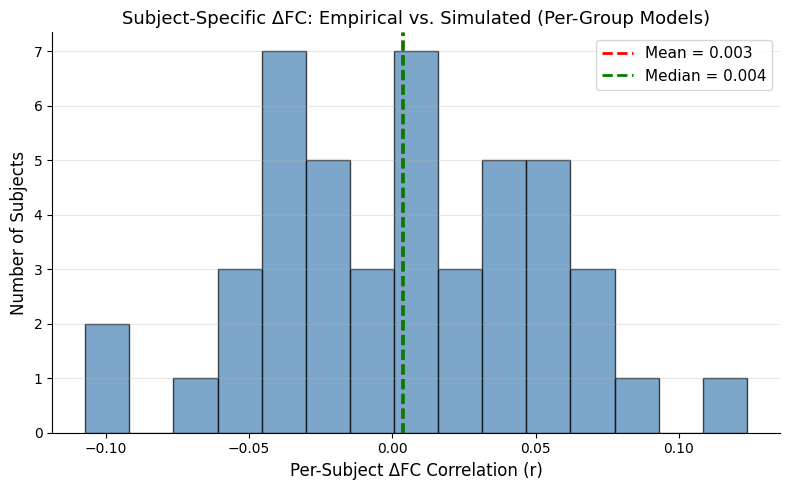

In [14]:
# =========================
# 13) Visualization: Histogram of correlations
# =========================
fig, ax = plt.subplots(figsize=(8, 5))

ax.hist(corrs_valid, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax.axvline(corrs_valid.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {corrs_valid.mean():.3f}')
ax.axvline(np.median(corrs_valid), color='green', linestyle='--', linewidth=2, label=f'Median = {np.median(corrs_valid):.3f}')

ax.set_xlabel('Per-Subject ΔFC Correlation (r)', fontsize=12)
ax.set_ylabel('Number of Subjects', fontsize=12)
ax.set_title('Subject-Specific ΔFC: Empirical vs. Simulated (Per-Group Models)', fontsize=13)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

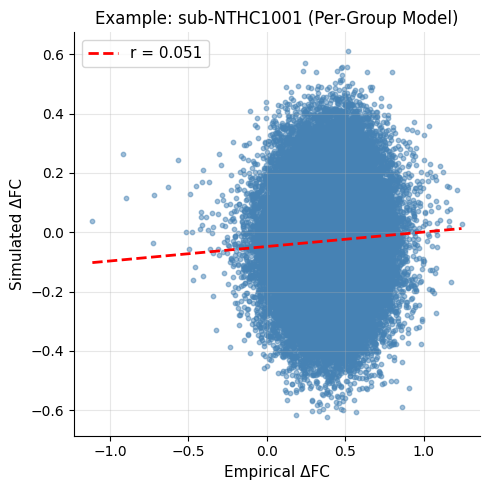

In [15]:
# =========================
# 14) Visualization: Scatter plot (example subject)
# =========================
if len(results['subject_deltafc_vec_emp']) > 0:
    example_sub = list(results['subject_deltafc_vec_emp'].keys())[0]
    vec_emp = results['subject_deltafc_vec_emp'][example_sub]
    vec_sim = results['subject_deltafc_vec_sim'][example_sub]
    r = results['subject_deltafc_corr'][example_sub]

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.scatter(vec_emp, vec_sim, s=10, alpha=0.5, color='steelblue')

    # Add regression line
    m, b = np.polyfit(vec_emp, vec_sim, 1)
    x_line = np.array([vec_emp.min(), vec_emp.max()])
    ax.plot(x_line, m*x_line + b, 'r--', linewidth=2, label=f'r = {r:.3f}')

    ax.set_xlabel('Empirical ΔFC', fontsize=11)
    ax.set_ylabel('Simulated ΔFC', fontsize=11)
    ax.set_title(f'Example: {example_sub} (Per-Group Model)', fontsize=12)
    ax.legend(fontsize=11)
    ax.grid(alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

In [16]:
# =========================
# 15) Save validation results
# =========================
results_summary = {
    'n_subjects': len(corrs_valid),
    'mean_r_deltafc': float(corrs_valid.mean()),
    'std_r_deltafc': float(corrs_valid.std()),
    'median_r_deltafc': float(np.median(corrs_valid)),
    'min_r_deltafc': float(corrs_valid.min()),
    'max_r_deltafc': float(corrs_valid.max()),
    'per_subject_correlations': {k: float(v) for k, v in results['subject_deltafc_corr'].items()},
}

results_path = os.path.join(OUT_DIR, "deltafc_validation_results.json")
with open(results_path, "w") as f:
    json.dump(results_summary, f, indent=2)

print(f"💾 Saved validation results to: {results_path}")
print(f"\n✅ All done!")

💾 Saved validation results to: /content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_vs_tms_fmri_pergroup/deltafc_validation_results.json

✅ All done!


In [ ]:
# Diagnostic

In [18]:
# =========================
# DIAGNOSTIC 1: Check if empirical ΔFC exists
# =========================
print("="*70)
print("DIAGNOSTIC 1: EMPIRICAL ΔFC MAGNITUDE")
print("="*70)

for sub_id in list(dataset_emp.keys())[:5]:  # Check first 5 subjects
    sub_emp = dataset_emp[sub_id]

    rest_runs = sub_emp.get("task-rest", {})
    stim_runs = sub_emp.get("task-stim", {})

    if len(rest_runs) == 0 or len(stim_runs) == 0:
        continue

    # Get rest FC
    rest_fc_list = []
    for run in rest_runs.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc = np.corrcoef(ts[:, 50:], rowvar=False)  # cortical only
            rest_fc_list.append(fc)

    # Get stim FC
    stim_fc_list = []
    for run in stim_runs.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc = np.corrcoef(ts[:, 50:], rowvar=False)
            stim_fc_list.append(fc)

    if rest_fc_list and stim_fc_list:
        FC_rest = np.mean(rest_fc_list, axis=0)
        FC_stim = np.mean(stim_fc_list, axis=0)
        deltaFC = FC_stim - FC_rest

        print(f"\n{sub_id}:")
        print(f"  Empirical ΔFC mean magnitude: {np.abs(deltaFC).mean():.6f}")
        print(f"  Empirical ΔFC max: {deltaFC.max():.4f}, min: {deltaFC.min():.4f}")
        print(f"  Empirical ΔFC std: {deltaFC.std():.6f}")


# =========================
# DIAGNOSTIC 2: Simulated ΔFC magnitude
# =========================
print("\n" + "="*70)
print("DIAGNOSTIC 2: SIMULATED ΔFC MAGNITUDE")
print("="*70)

for sub_id in list(dataset_sim.keys())[:5]:
    sub_sim = dataset_sim[sub_id]

    rest_runs = sub_sim.get("task-rest", {})
    stim_runs = sub_sim.get("task-stim", {})

    if len(rest_runs) == 0 or len(stim_runs) == 0:
        continue

    rest_fc_list = []
    for run in rest_runs.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc = np.corrcoef(ts[:, 50:], rowvar=False)
            rest_fc_list.append(fc)

    stim_fc_list = []
    for run in stim_runs.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc = np.corrcoef(ts[:, 50:], rowvar=False)
            stim_fc_list.append(fc)

    if rest_fc_list and stim_fc_list:
        FC_rest = np.mean(rest_fc_list, axis=0)
        FC_stim = np.mean(stim_fc_list, axis=0)
        deltaFC = FC_stim - FC_rest

        print(f"\n{sub_id}:")
        print(f"  Simulated ΔFC mean magnitude: {np.abs(deltaFC).mean():.6f}")
        print(f"  Simulated ΔFC max: {deltaFC.max():.4f}, min: {deltaFC.min():.4f}")
        print(f"  Simulated ΔFC std: {deltaFC.std():.6f}")


# =========================
# DIAGNOSTIC 3: Compare rest FC empirical vs simulated
# =========================
print("\n" + "="*70)
print("DIAGNOSTIC 3: REST FC CORRELATION (Empirical vs Simulated)")
print("="*70)

for sub_id in list(dataset_emp.keys())[:5]:
    if sub_id not in dataset_sim:
        continue

    sub_emp = dataset_emp[sub_id]
    sub_sim = dataset_sim[sub_id]

    # Empirical rest FC
    rest_runs_emp = sub_emp.get("task-rest", {})
    fc_emp_list = []
    for run in rest_runs_emp.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_emp_list.append(np.corrcoef(ts[:, 50:], rowvar=False))

    # Simulated rest FC
    rest_runs_sim = sub_sim.get("task-rest", {})
    fc_sim_list = []
    for run in rest_runs_sim.values():
        ts = run.get("time series", None)
        if isinstance(ts, np.ndarray) and ts.shape[1] >= 450:
            fc_sim_list.append(np.corrcoef(ts[:, 50:], rowvar=False))

    if fc_emp_list and fc_sim_list:
        FC_emp = np.mean(fc_emp_list, axis=0)
        FC_sim = np.mean(fc_sim_list, axis=0)

        tri = np.triu_indices(FC_emp.shape[0], k=1)
        r = np.corrcoef(FC_emp[tri], FC_sim[tri])[0, 1]

        print(f"{sub_id}: r(FC_rest) = {r:.4f}")

DIAGNOSTIC 1: EMPIRICAL ΔFC MAGNITUDE

sub-NTHC1001:
  Empirical ΔFC mean magnitude: 0.388188
  Empirical ΔFC max: 1.2397, min: -1.1117
  Empirical ΔFC std: 0.165031

sub-NTHC1003:
  Empirical ΔFC mean magnitude: 0.197505
  Empirical ΔFC max: 1.3922, min: -1.5796
  Empirical ΔFC std: 0.261187

sub-NTHC1009:
  Empirical ΔFC mean magnitude: 0.137555
  Empirical ΔFC max: 0.7119, min: -0.9064
  Empirical ΔFC std: 0.167820

sub-NTHC1015:
  Empirical ΔFC mean magnitude: 0.110422
  Empirical ΔFC max: 0.8486, min: -0.5929
  Empirical ΔFC std: 0.134435

sub-NTHC1016:
  Empirical ΔFC mean magnitude: 0.204631
  Empirical ΔFC max: 0.8663, min: -0.7193
  Empirical ΔFC std: 0.197112

DIAGNOSTIC 2: SIMULATED ΔFC MAGNITUDE

sub-NTHC1001:
  Simulated ΔFC mean magnitude: 0.125981
  Simulated ΔFC max: 0.6118, min: -0.6238
  Simulated ΔFC std: 0.155654

sub-NTHC1003:
  Simulated ΔFC mean magnitude: 0.143179
  Simulated ΔFC max: 0.7336, min: -0.4678
  Simulated ΔFC std: 0.145768

sub-NTHC1009:
  Simulated 

In [21]:
# =========================
# DIAGNOSTIC 4: PER-GROUP MODEL TRAINING QUALITY
# =========================
print("\n" + "="*70)
print("DIAGNOSTIC 4: PER-GROUP MODEL TRAINING QUALITY")
print("="*70)

import json
models_dir = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/trained_models_MLP_tms_fmri_pergroup"

# Fixed: use split('_')[2] instead of [1]
for target_id in sorted([int(f.split('_')[2]) for f in os.listdir(models_dir) if f.startswith('results_target')]):
    results_path = os.path.join(models_dir, f"results_target_{target_id:03d}_MLP_tms_fmri.json")
    if os.path.exists(results_path):
        with open(results_path) as f:
            res = json.load(f)

        final_train_loss = res['train_loss'][-1]
        final_test_loss = res['test_loss'][-1]
        n_subjects = res['n_subjects']

        print(f"Target {target_id} ({n_subjects} subjects): train_loss={final_train_loss:.6f}, test_loss={final_test_loss:.6f}")


DIAGNOSTIC 4: PER-GROUP MODEL TRAINING QUALITY
Target 155 (40 subjects): train_loss=0.052693, test_loss=0.314419
Target 220 (27 subjects): train_loss=0.044851, test_loss=0.423876
Target 231 (42 subjects): train_loss=0.055132, test_loss=0.292381
Target 305 (41 subjects): train_loss=0.055356, test_loss=0.311038
Target 342 (39 subjects): train_loss=0.053111, test_loss=0.304243
Target 359 (41 subjects): train_loss=0.057543, test_loss=0.302925
Target 366 (36 subjects): train_loss=0.051860, test_loss=0.329322
Target 386 (29 subjects): train_loss=0.047157, test_loss=0.385551
Target 392 (33 subjects): train_loss=0.047903, test_loss=0.335901
Target 401 (43 subjects): train_loss=0.051570, test_loss=0.290334
Target 403 (41 subjects): train_loss=0.054120, test_loss=0.304011


In [19]:

# =========================
# DIAGNOSTIC 5: Population vs Per-Group model (if population exists)
# =========================
print("\n" + "="*70)
print("DIAGNOSTIC 5: POPULATION MODEL vs PER-GROUP")
print("="*70)

pop_results_path = "/content/drive/MyDrive/Colab Notebooks/Brain_Stim_ANN/data/preprocessed_subjects_tms_fmri/ANN_results_MLP_tms_fmri_population.json"
if os.path.exists(pop_results_path):
    with open(pop_results_path) as f:
        pop_res = json.load(f)
    print(f"Population model final test loss: {pop_res['test_loss'][-1]:.6f}")
    print(f"Population model trained on {pop_res['n_subjects']} subjects")
else:
    print("Population model results not found")


DIAGNOSTIC 5: POPULATION MODEL vs PER-GROUP
Population model final test loss: 0.279332
Population model trained on 46 subjects
